In [5]:
# Data Prep
# import modules and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from scipy import stats

my_dir = os.path.realpath('.')
db_file = os.path.join(my_dir, '../../gr_sentiment_analysis/data/books.db')
conn = sqlite3.connect(db_file)

review_stats = pd.read_sql_query('SELECT * FROM review_stats',con=conn)

# Clean up the data a bit. Remove reviews with a score of 0 since they won't be part of the prediction model 

review_stats = review_stats[review_stats['rating'] != 0]

# Review ID is not needed for this analysis so should be dropped
if review_stats.columns.contains('review_id'):
    review_stats.drop('review_id', axis=1, inplace=True)

# remove any reviews with a total AFINN or Bing count of 0, since this means there are no matching
# words in either lexicon and these reviews cannot be used in this analysis
review_stats = review_stats[(review_stats.total_afinn_count != 0) & (review_stats.total_bing_count != 0)
                           & (review_stats.total_mpqa_count != 0) & (review_stats.total_inq_count != 0)]
# this leaves 877941 total reviews

# remove outliers where the Z-score of the pos or neg word counts is < 3
review_stats = review_stats[(
    np.abs(stats.zscore(review_stats[['pos_afinn_count', 'neg_afinn_count', 
                                      'pos_bing_count', 'neg_bing_count',
                                      'pos_mpqa_count', 'neg_mpqa_count',
                                      'pos_inq_count', 'neg_inq_count']])) < 3
).all(axis=1)]

# with all outliers removed (having a count +/- 3 SDs), 889807 rows remain. 

# Rating is our target variable, the other columns are features. 
y = review_stats['rating'].values
X = review_stats.drop('rating', axis=1).values

# Create a training and testing set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)


In [6]:
# with all outliers removed (having a count +/- 3 SDs), 889807 rows remain. 

# Next I want to apply One-hot encoding to the rating column, since we're going to attempt to 
# classify per rating. 

one_hot = pd.get_dummies(review_stats['rating'])
# and join back with the original data
review_stats_onehot = one_hot.join(review_stats)

# let's start with the 5s and see how well our model can predict 5/not 5

review_stats_5 = review_stats_onehot.drop([1,2,3,4,'rating'], axis=1)

# 5 is our target variable, the other columns are features. 
X = review_stats.drop('rating', axis=1).values
y_5 = one_hot[5].values

# # Create a training and testing set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_5, test_size=0.2, random_state=1)


In [7]:
# Setup MLP
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import RandomizedSearchCV

mlp = MLPClassifier()

param_mlp = {'hidden_layer_sizes': [(10,), (20,), (30,), (40,)], 
             'tol': stats.uniform(1e-06, 1e-02),
             'alpha':stats.uniform(1e-08, 1e-03),
             'learning_rate': ['constant', 'invscaling', 'adaptive'],
             'activation': ['identity', 'logistic', 'relu', 'tanh']}

def fit_RandomSearchCV(classifier, param_rand, X_train, y_train):
    rand_cv = RandomizedSearchCV(classifier, param_rand, cv=5, n_iter=20, n_jobs=2)
    rand_cv.fit(X_train, y_train)
    return rand_cv


In [8]:
mlp_5 = fit_RandomSearchCV(mlp, param_mlp, X_train, y_train)

mlp_5_y_pred = mlp_5.predict(X_test)

#stats 
from sklearn.metrics import classification_report
print(mlp_5.best_params_)
print(mlp_5.best_score_)
print(classification_report(y_test, mlp_5_y_pred))



{'activation': 'logistic', 'alpha': 0.00079015859626406395, 'hidden_layer_sizes': (20,), 'learning_rate': 'invscaling', 'tol': 0.008996288956133627}
0.715253889787
             precision    recall  f1-score   support

          0       0.73      0.94      0.82    123603
          1       0.56      0.17      0.26     51986

avg / total       0.68      0.71      0.66    175589



In [9]:
from sklearn.metrics import accuracy_score


In [10]:
# Does Random Forest work any better on predicting the 5s vs non-5s?
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_5, test_size=0.2, random_state=1)

rf.fit(X_train, y_train)
y_pred_rf_5 = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf_5))


             precision    recall  f1-score   support

          0       0.72      0.91      0.81    123603
          1       0.45      0.17      0.25     51986

avg / total       0.64      0.69      0.64    175589



In [11]:
# Let's try the same thing again, predicting the 4s.
y_4 = one_hot[4]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_4, test_size=0.2, random_state=1)

mlp_4 = fit_RandomSearchCV(mlp, param_mlp, X_train, y_train)

mlp_4_y_pred = mlp_4.predict(X_test)

#stats 
from sklearn.metrics import classification_report
print(mlp_4.best_params_)
print(mlp_4.best_score_)
print(classification_report(y_test, mlp_4_y_pred))

{'activation': 'tanh', 'alpha': 4.2379533290348427e-05, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'tol': 0.0018764580420794674}
0.649957571132
             precision    recall  f1-score   support

          0       0.65      1.00      0.79    114168
          1       0.50      0.00      0.00     61421

avg / total       0.60      0.65      0.51    175589



In [12]:
# And with the 3s
y_3 = one_hot[3]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_3, test_size=0.2, random_state=1)

mlp_3 = fit_RandomSearchCV(mlp, param_mlp, X_train, y_train)

mlp_3_y_pred = mlp_3.predict(X_test)

#stats 
from sklearn.metrics import classification_report
print(mlp_3.best_params_)
print(mlp_3.best_score_)
print(classification_report(y_test, mlp_3_y_pred))

{'activation': 'logistic', 'alpha': 0.00076721832098188285, 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling', 'tol': 0.0040359846027053147}
0.774053466068
             precision    recall  f1-score   support

          0       0.77      1.00      0.87    135795
          1       0.00      0.00      0.00     39794

avg / total       0.60      0.77      0.67    175589



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
# With the 2s
y_2 = one_hot[2]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_2, test_size=0.2, random_state=1)

mlp_2 = fit_RandomSearchCV(mlp, param_mlp, X_train, y_train)

mlp_2_y_pred = mlp_2.predict(X_test)

#stats 
from sklearn.metrics import classification_report
print(mlp_2.best_params_)
print(mlp_2.best_score_)
print(classification_report(y_test, mlp_2_y_pred))

{'activation': 'tanh', 'alpha': 0.0009261035832554053, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'tol': 0.0029497365460113339}
0.910672995877
             precision    recall  f1-score   support

          0       0.91      1.00      0.95    159803
          1       0.00      0.00      0.00     15786

avg / total       0.83      0.91      0.87    175589



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
# Lastly the 1s
y_1 = one_hot[1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_1, test_size=0.2, random_state=1)

mlp_1 = fit_RandomSearchCV(mlp, param_mlp, X_train, y_train)

mlp_1_y_pred = mlp_2.predict(X_test)

#stats 
from sklearn.metrics import classification_report
print(mlp_1.best_params_)
print(mlp_1.best_score_)
print(classification_report(y_test, mlp_1_y_pred))


{'activation': 'logistic', 'alpha': 1.6199591208298218e-05, 'hidden_layer_sizes': (40,), 'learning_rate': 'invscaling', 'tol': 0.0067458643854741733}
0.961989145044
             precision    recall  f1-score   support

          0       0.96      1.00      0.98    168987
          1       0.00      0.00      0.00      6602

avg / total       0.93      0.96      0.94    175589



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
# what about 2 variable classification? How does that work with MLP

# reviews with ratings of 4 and 5 are considered "positive" and 1-3 are "not positive"
review_stats['pos_review'] = 0
review_stats.loc[review_stats['rating'] >= 4,'pos_review'] = 1


y_pos = review_stats['pos_review'].values
# don't include rating or pos_review in our X values
X_pos = review_stats.drop(['rating', 'pos_review'], axis=1).values

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
    X_pos, y_pos, test_size=0.2, random_state=1)

mlp = MLPClassifier(hidden_layer_sizes=(20,), activation='logistic', alpha=0.0008883, learning_rate='invscaling', 
                   tol=0.000583)

mlp.fit(X_train_pos, y_train_pos)
mlp_y_new_pred = mlp.predict(X_test_pos)
print(classification_report(y_test_pos, mlp_y_new_pred))

             precision    recall  f1-score   support

          0       0.54      0.27      0.36     62182
          1       0.69      0.87      0.77    113407

avg / total       0.63      0.66      0.62    175589



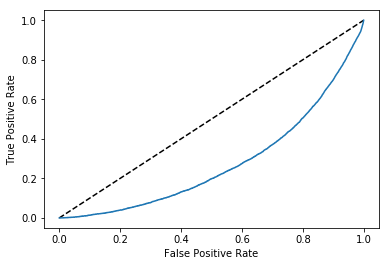

In [16]:
from sklearn.metrics import roc_curve

y_pred_prob = mlp.predict_proba(X_test)[:,1]
# we unpack the result into three variables: False Postiive Rate
# True Positive Rate, and Thresholds (the values of p)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()